In [1]:
# Imports
import sys
sys.path.append('../')
from config import *

In [2]:
# U-Net Model Architecture


class UNet(nn.Module):
    def __init__(self, input_channels, num_classes, sequence = [64, 128, 256, 512, 1024]):
        super(UNet, self).__init__()

        self.encoders = []
        self.encoders.append(self.conv_block(input_channels, sequence[0]))
        for i in range(1, len(sequence)-1):
            self.encoders.append(self.conv_block(sequence[i-1], sequence[i]))
        self.encoders = nn.ModuleList(self.encoders)

        self.bottleneck = self.conv_block(sequence[-2], sequence[-1])

        self.decoders = []
        for i in range(len(sequence)-1, 0, -1):
            self.decoders.append(self.upconv_block(sequence[i], sequence[i-1]))
            self.decoders.append(self.conv_block(sequence[i], sequence[i-1]))
        self.decoders = nn.ModuleList(self.decoders)

        self.final_conv = nn.Conv2d(sequence[0], num_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):

        encoders_out = []
        for encoder in self.encoders:
            x = encoder(x)
            encoders_out.append(x)
            x = F.max_pool2d(x, kernel_size=2)

        x = self.bottleneck(x)

        for i in range(len(self.decoders)//2):
            x = self.decoders[i*2](x)
            x = torch.cat((x, encoders_out[-(i+1)]), dim=1)
            x = self.decoders[i*2+1](x)

        return self.final_conv(x)

In [3]:
# Load Dataset

X = []
y = []

distribution = [0]*7

pathX = '../data/dataset/X'
pathY = '../data/dataset/y'
files = [f for f in os.listdir(pathX) if f.endswith('.tif')]

# load data from files
for file in files:
    X.append(rio.open(os.path.join(pathX, file)).read())
    y.append(rio.open(os.path.join(pathY, file)).read())

# flatten outputs
for i in range(len(X)):
    X[i] = np.moveaxis(X[i], 0, -1)
    y[i] = np.moveaxis(y[i], 0, -1)
    for j in range(len(y[i])):
        for k in range(len(y[i][j])):
            distribution[y[i][j][k][0]] += 1

distribution = np.array(distribution)
distribution = distribution / np.sum(distribution)

print('X shape:', np.array(X).shape)
print('y shape:', np.array(y).shape)    

X shape: (1998, 16, 16, 8)
y shape: (1998, 16, 16, 1)


In [4]:
# Training Parameters

model = UNet(
    input_channels=8,
    num_classes=7,
    sequence=enclayers
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001) #Adam optimizer with a learning rate of 0.001.


# input augmentation with transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]

        if self.transform:
            x = self.transform(x)

        return x, y

dataset = CustomDataset(X, y, transform=transform)

train_size = int(0.8 * len(dataset)) #80% of the data for training.
test_size = len(dataset) - train_size #20% of the data for testing.

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size]) #Splitting the dataset into training and testing sets.

In [5]:
# Loss function and Class Weighting

class_weights = 1/distribution
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device) #Convert the class weights to a PyTorch tensor and move it to the device (GPU or CPU).

cross_entropy = torch.nn.CrossEntropyLoss(reduction='none', weight=class_weights) #Cross entropy loss function with inverse class weights.

# Custom loss function to weight individual cross entropies.
def loss_fn(outputs, labels):
    # the error margin is how far the predicted class can be from an instance of the true class before being counted as an error.
    losses = []

    outputs = torch.moveaxis(outputs, 0, -1)
    labels = labels.reshape(decision_width, decision_width)


    for i in range(0, decision_width):
        for j in range(0, decision_width):
            output = outputs[i, j]
            label = labels[i, j]
            loss = cross_entropy(output, label)
            losses.append(loss)
    
    return torch.stack(losses).mean()

# Directly weighing dataset by class combination. (sum of weights)
# weights = torch.tensor(np.zeros(len(train_dataset)), dtype=torch.float32) #Initialize weights to zero.
# 
# for i in range(len(train_dataset)): #loop through each training sample
#     train = train_dataset[i][1].reshape(decision_width*decision_width, 7).argmax(axis=1) #Reshape the training sample to a 2D array.
#     for cl in train:
#         weights[i] += classWeights[cl] #Add the class weight to the sample weight.
# sampler = WeightedRandomSampler(weights, len(weights), replacement=True)
# 
# train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #DataLoader for testing data.



In [7]:
# Testing
model.eval()

correct = 0
total = 0
running_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device) #Move data to GPU if available.

        outputs = model(inputs)

        loss = [loss_fn(out, label) for out, label in zip(outputs, labels)] #Calculate the loss.
        loss = torch.stack(loss).mean()

        running_loss += loss.item() #Accumulate loss.
        total += labels.size(0)*decision_width*decision_width #Total number of samples.
        
        for label, output in zip(labels, outputs):
            output= output.argmax(dim=0).unsqueeze(-1)
            correct+= (label == output).sum().item() #Count correct predictions.

accuracy = 100 * correct / total #Calculate accuracy.

print(f'Test Loss: {running_loss/len(test_loader):.4f}, Test Accuracy: {accuracy:.2f}%')

Test Loss: 4.7908, Test Accuracy: 88.25%


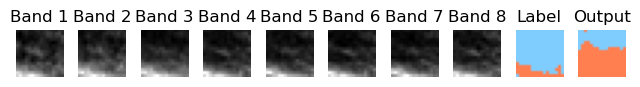

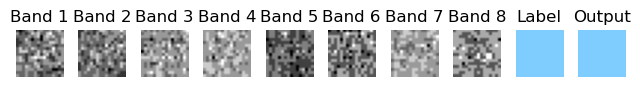

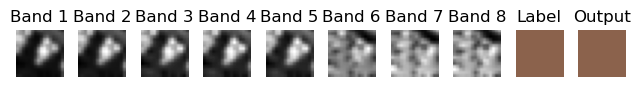

In [8]:
# Visualize Model Predictions
inputs, labels = random.choice(list(test_loader))
inputs, labels = inputs.to(device), labels.to(device) #Move data to GPU if available.

outputs = model(inputs)
outputs = outputs.cpu().detach().numpy()
labels = labels.cpu().detach().numpy()

for _ in range(3):
    ind = random.randint(0, len(inputs)-1)
    input, label, output = inputs[ind], labels[ind], outputs[ind] 
    
    # show 8 input bands
    for band in range(8):
        plt.subplot(1, 10, band+1)
        plt.imshow(input[band].cpu().numpy(), cmap='gray')
        plt.title('Band {}'.format(band+1))
        plt.axis('off')

    # show output and label
    plt.subplot(1,10,9)

    colored_label = np.zeros((decision_width, decision_width, 3), dtype=np.uint8)
    for class_id, color in classColors.items():
        colored_label[(label[:, :, 0] == class_id)] = color  # Fix boolean indexing
    
    plt.imshow(colored_label)
    plt.title('Label')
    plt.axis('off')

    plt.subplot(1,10,10)

    output = output.argmax(0)
    colored_output = np.zeros((decision_width, decision_width, 3), dtype=np.uint8)
    for class_id, color in classColors.items():
        colored_output[(output == class_id)] = color  # Fix boolean indexing

    plt.imshow(colored_output)
    plt.title('Output')
    plt.axis('off')
    plt.tight_layout()
    plt.show()    


True Positives: [7158, 11510, 30024, 44639, 32106, 181980, 146471]
False Positives: [43, 19445, 15212, 8736, 12432, 1521, 211]
False Negatives: [0, 6190, 9371, 18283, 10415, 4010, 9331]


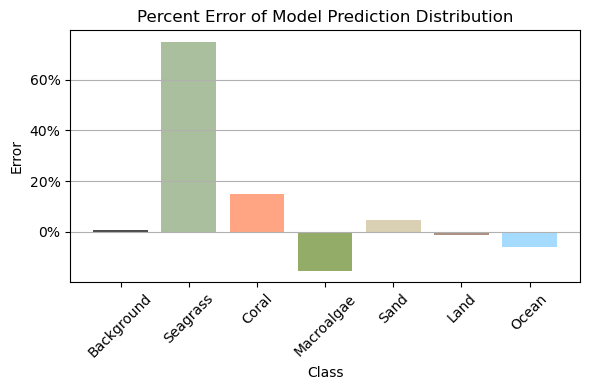

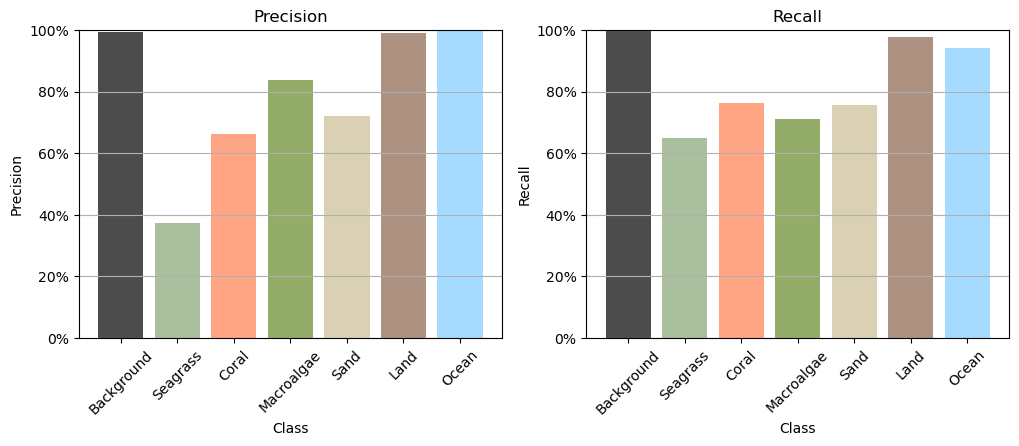

In [9]:
# Class Metrics

# calculate tp, tn, fp, fn for each class, then APRF1 ([[]*4]*7)
labelcount = {i:0 for i in range(7)}
outcount = {i:0 for i in range(7)}
tp = [0]*7
fp = [0]*7
fn = [0]*7

with torch.no_grad():
    for x, yi in zip(X, y):
        x = torch.tensor(x, dtype=torch.float32).to(device)
        x = x.permute(2, 0, 1) # Move channels to first dimension
        x = x.unsqueeze(0) # Add batch dimension

        segmentation = model(x)

        segmentation = torch.moveaxis(segmentation, 1, -1).argmax(-1).cpu().detach().numpy().flatten()
        yi = yi.flatten()

        for i in range(0, len(yi)):

            labelcount[yi[i]] += 1
            outcount[segmentation[i]] += 1

            if yi[i] == segmentation[i]:
                tp[yi[i]] += 1
            else:
                fp[segmentation[i]] += 1
                fn[yi[i]] += 1
        
outcount = dict(sorted(outcount.items()))
labelcount = dict(sorted(labelcount.items()))

precisions = [0]*7
recalls = [0]*7

for i in range(7):
    if tp[i] + fp[i] != 0:
        precisions[i] = tp[i] / (tp[i] + fp[i])
    if tp[i] + fn[i] != 0:
        recalls[i] = tp[i] / (tp[i] + fn[i])

print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)

# plot deviation bar diagram using the % error of the counts from the model and the counts from the labels 
# (higher value -> model overpredicts, lower value -> model underpredicts)
plt.figure(figsize=(6, 4))
plt.bar(classNames.values(), [(outcount[i] - labelcount[i] )/(labelcount[i] + 1e-6) for i in labelcount.keys()], color=classColorsNormalized.values(), alpha=0.7)
plt.title('Percent Error of Model Prediction Distribution')
plt.xlabel('Class')
plt.ylabel('Error')
# plt.ylim(-1, 1)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# plot precision and recall histograms in subplot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(classNames.values(), precisions, color=classColorsNormalized.values(), alpha=0.7)
plt.title('Precision')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.grid(axis='y')

plt.subplot(1, 2, 2)
plt.bar(classNames.values(), recalls, color=classColorsNormalized.values(), alpha=0.7)
plt.title('Recall')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.grid(axis='y')
plt.show()

WV10212021_aganaClip.tif


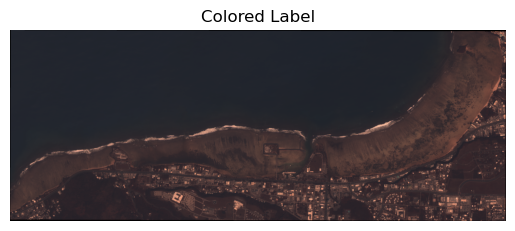

0.00% done
9.60% done
19.21% done
28.81% done
38.42% done
48.02% done
57.62% done
67.23% done
76.83% done
86.43% done
96.04% done


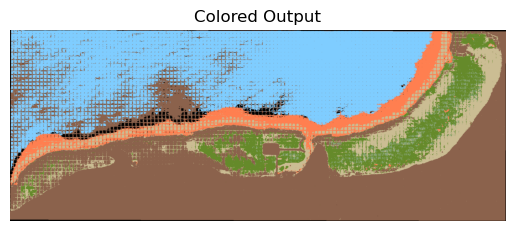

Image Segmentation Time: 24.71s
WV3_01112021_aganaclip.tif


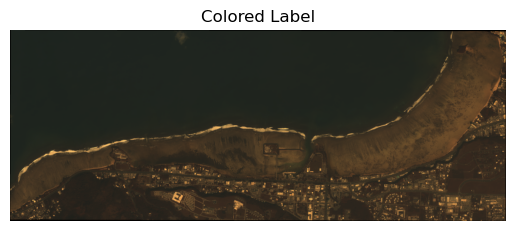

0.00% done
9.60% done
19.21% done
28.81% done
38.42% done
48.02% done
57.62% done
67.23% done
76.83% done
86.43% done
96.04% done


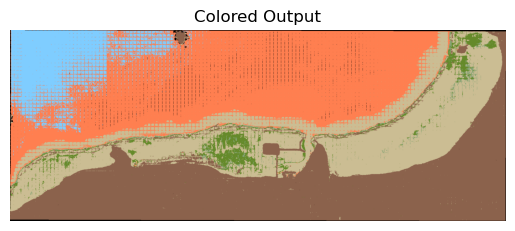

Image Segmentation Time: 49.14s
WV3_01182021_aganaClip.tif


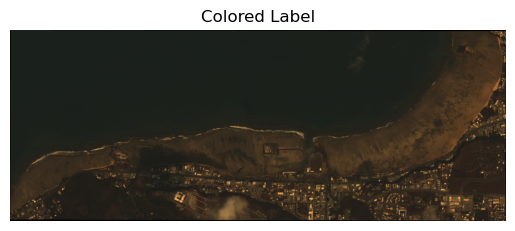

0.00% done
9.60% done
19.21% done
28.81% done
38.42% done
48.02% done
57.62% done
67.23% done
76.83% done
86.43% done
96.04% done


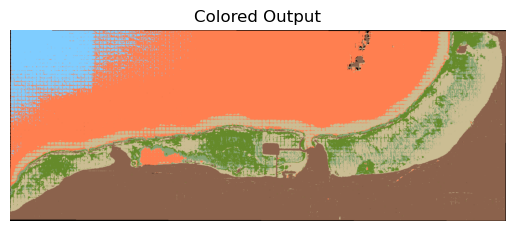

Image Segmentation Time: 75.59s
WV3_07302023_AganaClip.tif


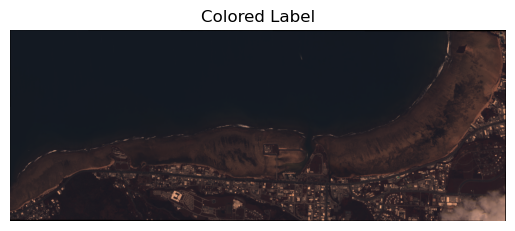

0.00% done
9.60% done
19.21% done
28.81% done
38.42% done
48.02% done
57.62% done
67.23% done
76.83% done
86.43% done
96.04% done


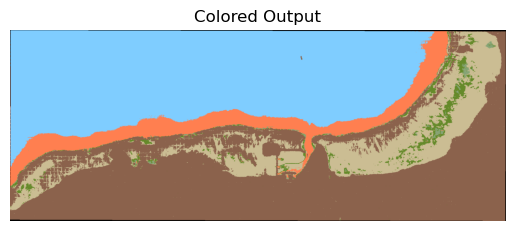

Image Segmentation Time: 215.12s
WV_01132022_AganaClip.tif


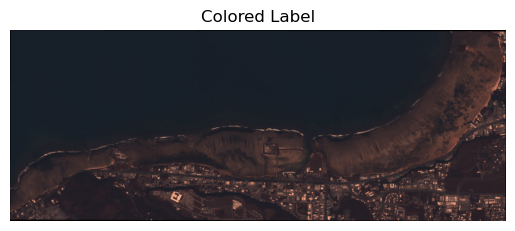

0.00% done
9.60% done
19.21% done
28.81% done
38.42% done
48.02% done
57.62% done
67.23% done
76.83% done
86.43% done
96.04% done


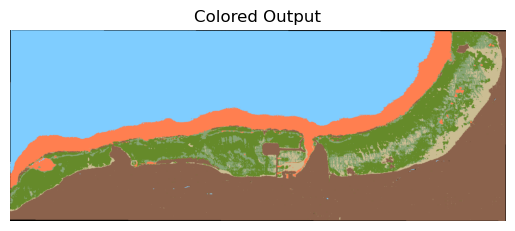

Image Segmentation Time: 240.04s
WV_01152013_AganaClip.tif


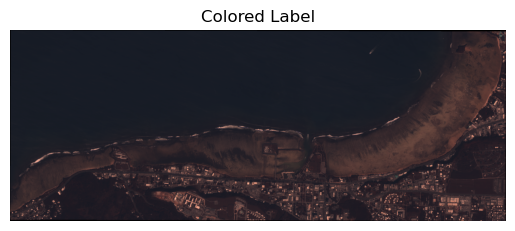

0.00% done
9.60% done
19.21% done
28.81% done
38.42% done
48.02% done
57.62% done
67.23% done
76.83% done
86.43% done
96.04% done


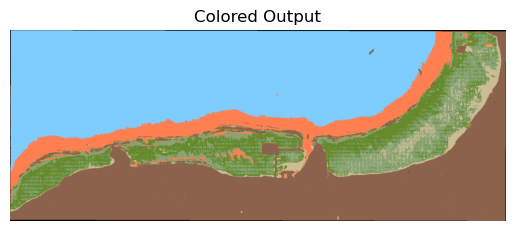

Image Segmentation Time: 264.67s
WV_02052014_aganaclip.tif


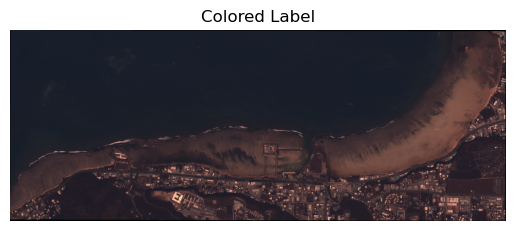

0.00% done
9.60% done
19.21% done
28.81% done
38.42% done
48.02% done
57.62% done
67.23% done
76.83% done
86.43% done
96.04% done


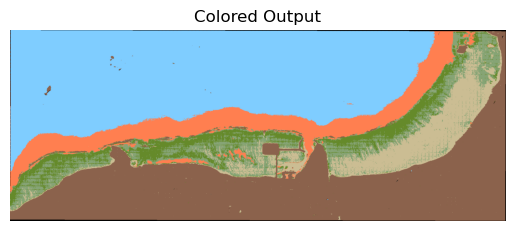

Image Segmentation Time: 294.17s
WV_02052023_AganaClip.tif


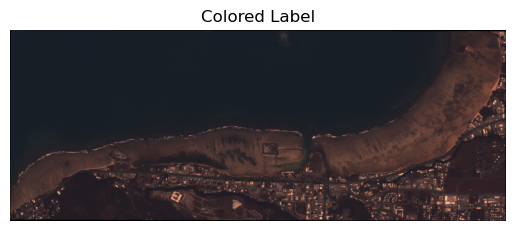

0.00% done
9.60% done
19.21% done
28.81% done
38.42% done
48.02% done
57.62% done
67.23% done
76.83% done
86.43% done
96.04% done


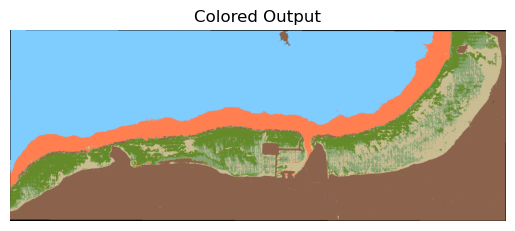

Image Segmentation Time: 322.61s
WV_02292020_AganaClip.tif


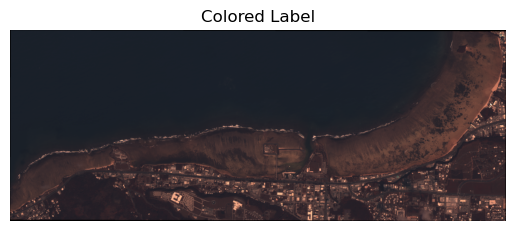

0.00% done
9.60% done
19.21% done
28.81% done
38.42% done
48.02% done
57.62% done
67.23% done
76.83% done
86.43% done
96.04% done


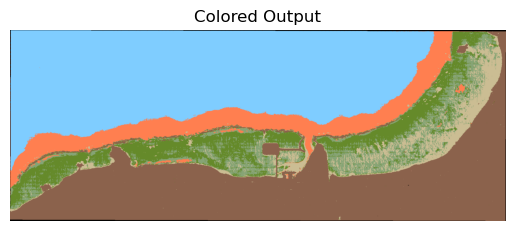

Image Segmentation Time: 351.73s
WV_03082022_composite_aganaclip.tif


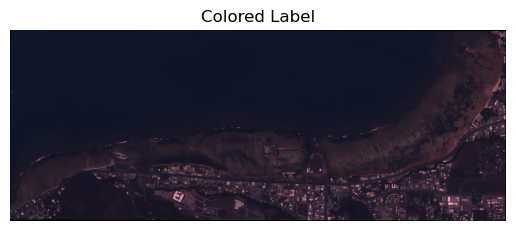

0.00% done
9.60% done
19.21% done
28.81% done
38.42% done
48.02% done
57.62% done
67.23% done
76.83% done
86.43% done
96.04% done


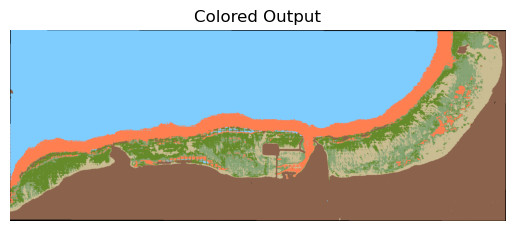

Image Segmentation Time: 381.13s
WV_05122018_aganaclip.tif


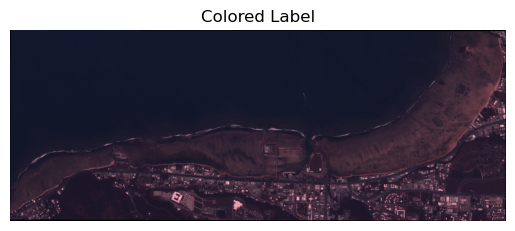

0.00% done
9.60% done
19.21% done
28.81% done
38.42% done
48.02% done
57.62% done
67.23% done
76.83% done
86.43% done
96.04% done


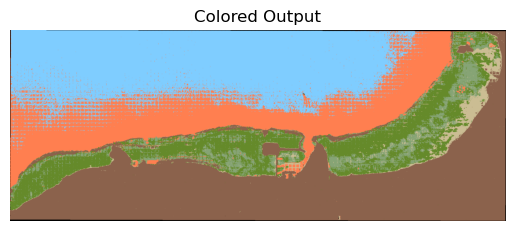

Image Segmentation Time: 409.65s
WV_07272015_AganaClip.tif


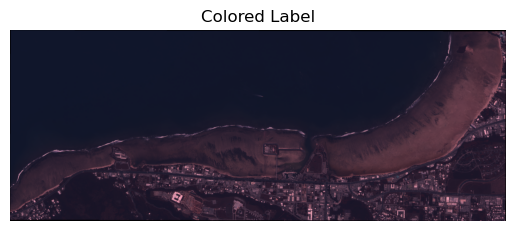

0.00% done
9.60% done
19.21% done
28.81% done
38.42% done
48.02% done
57.62% done
67.23% done
76.83% done
86.43% done
96.04% done


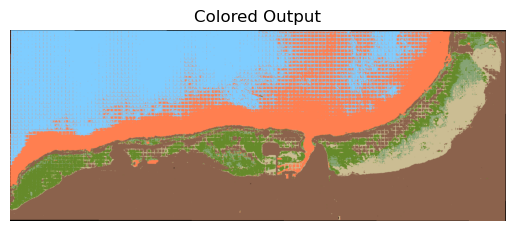

Image Segmentation Time: 437.57s
WV_10202017_aganaClip.tif


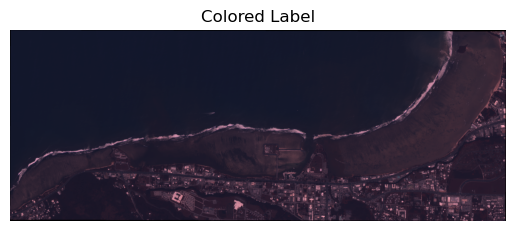

0.00% done
9.60% done
19.21% done
28.81% done
38.42% done
48.02% done
57.62% done
67.23% done
76.83% done
86.43% done
96.04% done


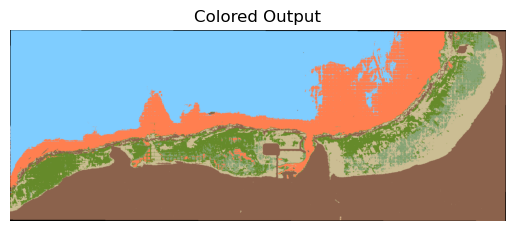

Image Segmentation Time: 465.89s
WV_11102016_Aganaclip.tif


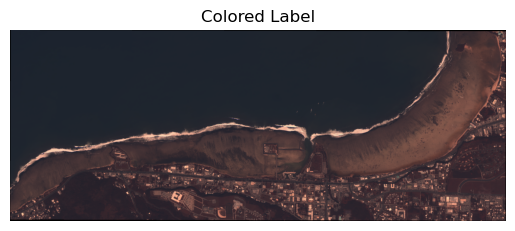

0.00% done
9.60% done
19.21% done
28.81% done
38.42% done
48.02% done
57.62% done
67.23% done
76.83% done
86.43% done
96.04% done


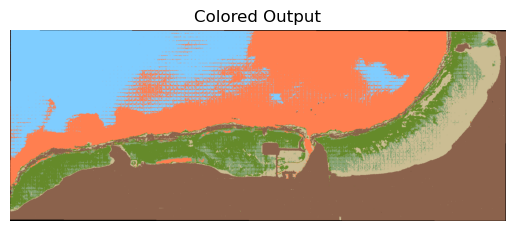

Image Segmentation Time: 493.02s
WV_12152010_AganaClip.tif


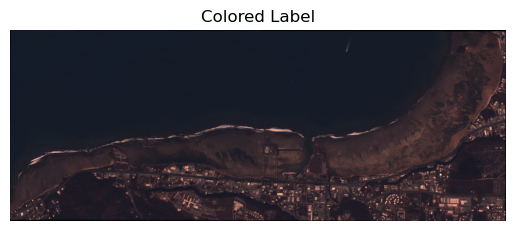

0.00% done
9.60% done
19.21% done
28.81% done
38.42% done
48.02% done
57.62% done
67.23% done
76.83% done
86.43% done
96.04% done


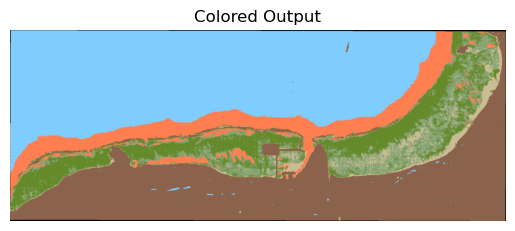

Image Segmentation Time: 520.79s


In [ ]:
# Full Image Prediction

generation_start_time = time.time() #Start time for full image prediction.

path = '../data/test_data/1/images/'
pathY = '../data/test_data/1/colored/'
files = [f for f in os.listdir(path) if f.endswith('.tif')]
filesY = [f for f in os.listdir(pathY) if f.endswith('.png')]


padding_width = (context_width - decision_width) // 2

for file, yfile in zip(files, filesY):
    print(file)
    imgX = rio.open(os.path.join(path, file)).read()

    width = imgX.shape[1]
    height = imgX.shape[2]
    width = int(np.ceil(width / decision_width)) * decision_width + 1
    height = int(np.ceil(height / decision_width)) * decision_width + 1
    imgX = np.pad(imgX, ((0, 0), (0, width - imgX.shape[1]), (0, height - imgX.shape[2])), mode='edge')
    imgX = np.pad(imgX, ((0, 0), (padding_width, padding_width), (padding_width, padding_width)), mode='edge')
    imgX = np.moveaxis(imgX, 0, -1)  # Move the channel dimension to the last position

    imgY = rio.open(os.path.join(pathY, yfile)).read()
    imgY = np.moveaxis(imgY, 0, -1)  # Move the channel dimension to the last position

    plt.imshow(imgY)
    plt.title('Colored Label')
    plt.axis('off')
    plt.show()


    # predict full image
    segmentation = np.zeros((width, height, 1), dtype=np.float32)
    for i in range(0, imgX.shape[0]-context_width, decision_width):
        for j in range(0, imgX.shape[1]-context_width, decision_width):
            x = torch.from_numpy(imgX[i:i + context_width, j:j + context_width, :]).float().to(device)
            x = x.permute(2, 0, 1).unsqueeze(0)  # Add batch dimension and permute to (batch_size, channels, height, width)
            
            out = model(x)
            out = torch.moveaxis(out, 1, -1).argmax(-1).unsqueeze(-1).cpu().detach().numpy()
            segmentation[i:i + decision_width, j:j + decision_width, :] = out

        if i//decision_width % 5 == 0:
            print(f"{i/imgX.shape[0]*100:.2f}% done")

    segmentation = segmentation[:imgY.shape[0], :imgY.shape[1], :]  # Remove padding
    output_path = os.path.join('../masksUNET/1/', file)
    with rio.open(
        output_path,
        'w',
        driver='GTiff',
        height=segmentation.shape[0],
        width=segmentation.shape[1],
        count=1,
        dtype=segmentation.dtype,
        crs=rio.open(os.path.join(path, file)).crs,
        transform=rio.open(os.path.join(path, file)).transform,
    ) as dst:
        dst.write(segmentation[:, :, 0], 1)

    colored_out = np.zeros((segmentation.shape[0], segmentation.shape[1], 3), dtype=np.uint8)

    for class_id, color in classColors.items():
        colored_out[segmentation[:, :, 0] == class_id] = color
    plt.imshow(colored_out)
    plt.title('Colored Output')
    plt.axis('off')
    plt.show()
    print(f'Image Segmentation Time: {time.time() - generation_start_time:.2f}s')

WV3_01132022_MGclip.tif


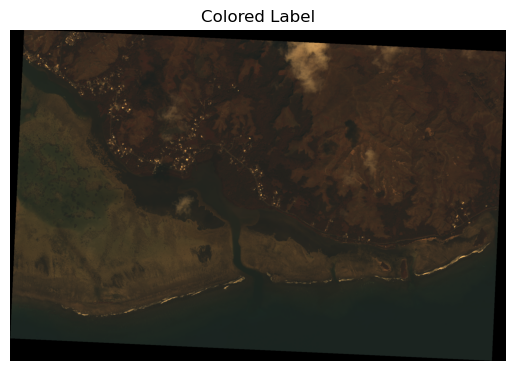

0.00% done
5.81% done
11.62% done
17.43% done
23.24% done
29.05% done
34.86% done
40.67% done
46.48% done
52.29% done
58.10% done
63.91% done
69.72% done
75.53% done
81.34% done
87.15% done
92.96% done
98.77% done


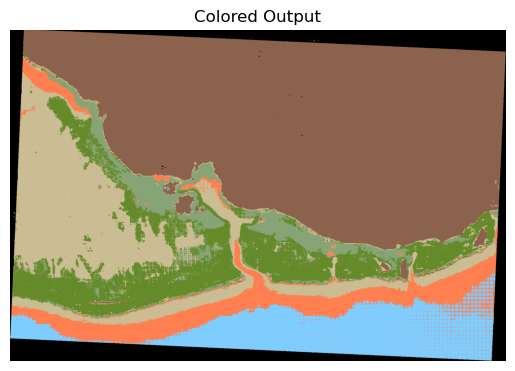

Image Segmentation Time: 43.83s
WV3_02202022_MGclip.tif


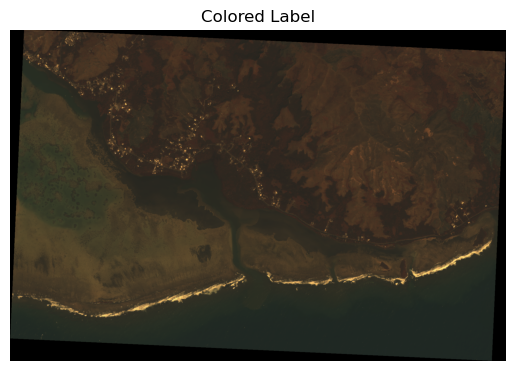

0.00% done
5.81% done
11.62% done
17.43% done
23.24% done
29.05% done
34.86% done
40.67% done
46.48% done
52.29% done
58.10% done
63.91% done
69.72% done
75.53% done
81.34% done
87.15% done
92.96% done
98.77% done


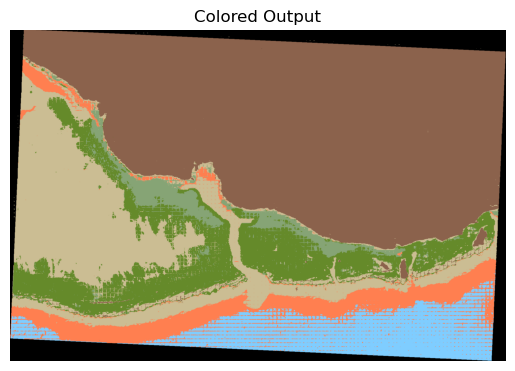

Image Segmentation Time: 89.18s
WV3_12302014_MGclip.tif


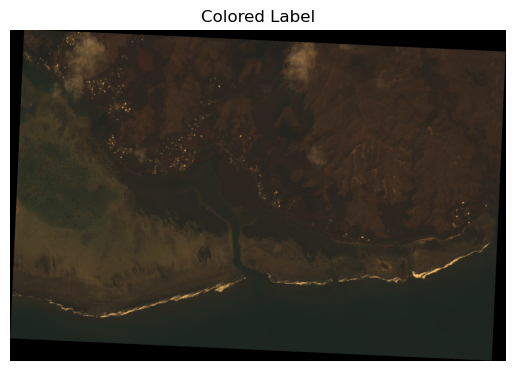

0.00% done
5.81% done
11.62% done
17.43% done
23.24% done
29.05% done
34.86% done
40.67% done
46.48% done
52.29% done
58.10% done
63.91% done
69.72% done
75.53% done
81.34% done
87.15% done
92.96% done
98.77% done


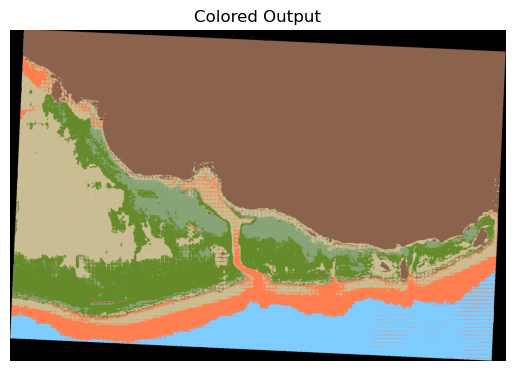

Image Segmentation Time: 134.56s
WV3_20220113_Composite_8bands_Manell_AOI_XSM_updated.tif


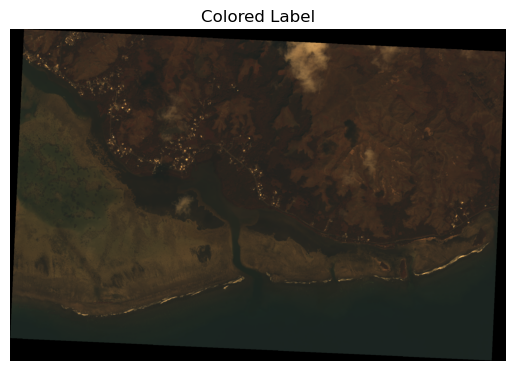

0.00% done
5.81% done
11.62% done
17.43% done
23.24% done
29.05% done
34.86% done
40.67% done
46.48% done
52.29% done
58.10% done
63.91% done
69.72% done
75.53% done
81.34% done
87.15% done
92.96% done
98.77% done


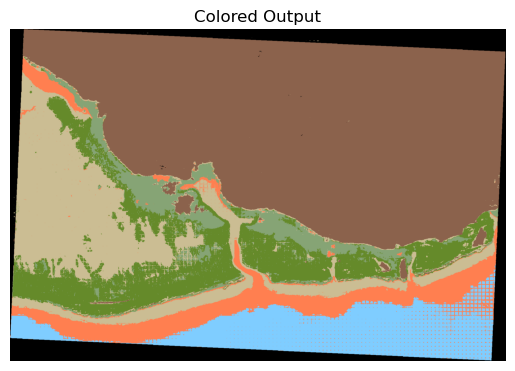

Image Segmentation Time: 182.69s
WV_MG_01052024_composite_clip.tif


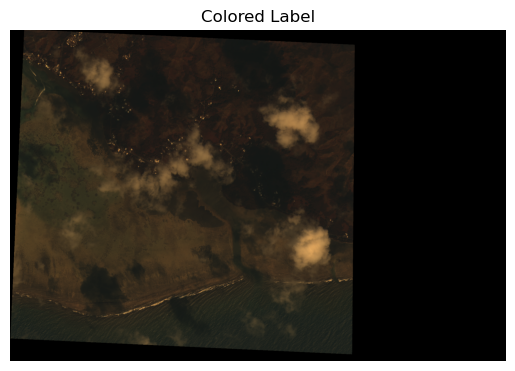

0.00% done
5.81% done
11.62% done
17.43% done
23.24% done
29.05% done
34.86% done
40.67% done
46.48% done
52.29% done
58.10% done
63.91% done
69.72% done
75.53% done
81.34% done
87.15% done
92.96% done
98.77% done


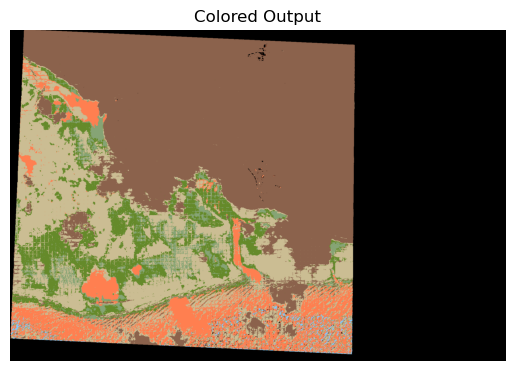

Image Segmentation Time: 227.00s
WV_MG_02142024_composite_clip.tif


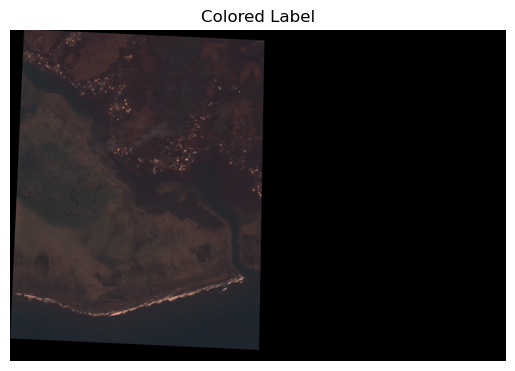

0.00% done
5.81% done
11.62% done
17.43% done
23.24% done
29.05% done
34.86% done
40.67% done
46.48% done
52.29% done
58.10% done
63.91% done
69.72% done
75.53% done
81.34% done
87.15% done
92.96% done
98.77% done


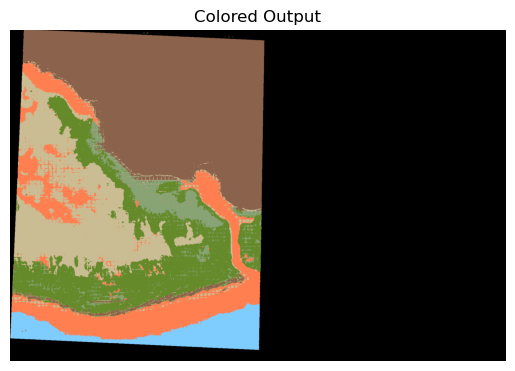

Image Segmentation Time: 272.51s


In [19]:
# Full Image Prediction

generation_start_time = time.time() #Start time for full image prediction.

path = '../data/test_data/3/images/'
pathY = '../data/test_data/3/colored/'
files = [f for f in os.listdir(path) if f.endswith('.tif')]
filesY = [f for f in os.listdir(pathY) if f.endswith('.png')]


padding_width = (context_width - decision_width) // 2

for file, yfile in zip(files, filesY):
    print(file)
    imgX = rio.open(os.path.join(path, file)).read()

    width = imgX.shape[1]
    height = imgX.shape[2]
    width = int(np.ceil(width / decision_width)) * decision_width + 1
    height = int(np.ceil(height / decision_width)) * decision_width + 1
    imgX = np.pad(imgX, ((0, 0), (0, width - imgX.shape[1]), (0, height - imgX.shape[2])), mode='edge')
    imgX = np.pad(imgX, ((0, 0), (padding_width, padding_width), (padding_width, padding_width)), mode='edge')
    imgX = np.moveaxis(imgX, 0, -1)  # Move the channel dimension to the last position

    imgY = rio.open(os.path.join(pathY, yfile)).read()
    imgY = np.moveaxis(imgY, 0, -1)  # Move the channel dimension to the last position

    plt.imshow(imgY)
    plt.title('Colored Label')
    plt.axis('off')
    plt.show()


    # predict full image
    segmentation = np.zeros((width, height, 1), dtype=np.float32)
    for i in range(0, imgX.shape[0]-context_width, decision_width):
        for j in range(0, imgX.shape[1]-context_width, decision_width):
            x = torch.from_numpy(imgX[i:i + context_width, j:j + context_width, :]).float().to(device)
            x = x.permute(2, 0, 1).unsqueeze(0)  # Add batch dimension and permute to (batch_size, channels, height, width)
            
            out = model(x)
            out = torch.moveaxis(out, 1, -1).argmax(-1).unsqueeze(-1).cpu().detach().numpy()
            segmentation[i:i + decision_width, j:j + decision_width, :] = out

        if i//decision_width % 5 == 0:
            print(f"{i/imgX.shape[0]*100:.2f}% done")

    segmentation = segmentation[:imgY.shape[0], :imgY.shape[1], :]  # Remove padding
    output_path = os.path.join('../masksUNET/3/', file)
    with rio.open(
        output_path,
        'w',
        driver='GTiff',
        height=segmentation.shape[0],
        width=segmentation.shape[1],
        count=1,
        dtype=segmentation.dtype,
        crs=rio.open(os.path.join(path, file)).crs,
        transform=rio.open(os.path.join(path, file)).transform,
    ) as dst:
        dst.write(segmentation[:, :, 0], 1)

    colored_out = np.zeros((segmentation.shape[0], segmentation.shape[1], 3), dtype=np.uint8)

    for class_id, color in classColors.items():
        colored_out[segmentation[:, :, 0] == class_id] = color
    plt.imshow(colored_out)
    plt.title('Colored Output')
    plt.axis('off')
    plt.show()
    print(f'Image Segmentation Time: {time.time() - generation_start_time:.2f}s')

In [20]:
# Full Image Prediction

generation_start_time = time.time() #Start time for full image prediction.

path = '../data/raw_labeled_data/images/'
pathY = '../data/raw_labeled_data/colored/'
files = [f for f in os.listdir(path) if f.endswith('.tif')]
filesY = [f for f in os.listdir(pathY) if f.endswith('.png')]


padding_width = (context_width - decision_width) // 2

for file, yfile in zip(files, filesY):
    print(file)
    imgX = rio.open(os.path.join(path, file)).read()

    width = imgX.shape[1]
    height = imgX.shape[2]
    width = int(np.ceil(width / decision_width)) * decision_width + 1
    height = int(np.ceil(height / decision_width)) * decision_width + 1
    imgX = np.pad(imgX, ((0, 0), (0, width - imgX.shape[1]), (0, height - imgX.shape[2])), mode='edge')
    imgX = np.pad(imgX, ((0, 0), (padding_width, padding_width), (padding_width, padding_width)), mode='edge')
    imgX = np.moveaxis(imgX, 0, -1)  # Move the channel dimension to the last position

    imgY = rio.open(os.path.join(pathY, yfile)).read()
    imgY = np.moveaxis(imgY, 0, -1)  # Move the channel dimension to the last position

    plt.imshow(imgY)
    plt.title('Colored Label')
    plt.axis('off')
    plt.show()


    # predict full image
    segmentation = np.zeros((width, height, 1), dtype=np.float32)
    for i in range(0, imgX.shape[0]-context_width, decision_width):
        for j in range(0, imgX.shape[1]-context_width, decision_width):
            x = torch.from_numpy(imgX[i:i + context_width, j:j + context_width, :]).float().to(device)
            x = x.permute(2, 0, 1).unsqueeze(0)  # Add batch dimension and permute to (batch_size, channels, height, width)
            
            out = model(x)
            out = torch.moveaxis(out, 1, -1).argmax(-1).unsqueeze(-1).cpu().detach().numpy()
            segmentation[i:i + decision_width, j:j + decision_width, :] = out

        if i//decision_width % 5 == 0:
            print(f"{i/imgX.shape[0]*100:.2f}% done")

    segmentation = segmentation[:imgY.shape[0], :imgY.shape[1], :]  # Remove padding
    output_path = os.path.join('../masksUNET/training/', file)
    with rio.open(
        output_path,
        'w',
        driver='GTiff',
        height=segmentation.shape[0],
        width=segmentation.shape[1],
        count=1,
        dtype=segmentation.dtype,
        crs=rio.open(os.path.join(path, file)).crs,
        transform=rio.open(os.path.join(path, file)).transform,
    ) as dst:
        dst.write(segmentation[:, :, 0], 1)

    colored_out = np.zeros((segmentation.shape[0], segmentation.shape[1], 3), dtype=np.uint8)

    for class_id, color in classColors.items():
        colored_out[segmentation[:, :, 0] == class_id] = color
    plt.imshow(colored_out)
    plt.title('Colored Output')
    plt.axis('off')
    plt.show()
    print(f'Image Segmentation Time: {time.time() - generation_start_time:.2f}s')